In [284]:
from scipy.io import loadmat
from sklearn.model_selection import train_test_split 
import numpy as np
from matplotlib import pyplot as plt

from sklearn.linear_model import LinearRegression



In [285]:
out = loadmat('training-data.mat')
XdataOut = out['u'].T
YdataOut = out['th'].T
size = XdataOut.size
subset_size = 100
random_select = np.random.choice(size, size=subset_size, replace=False) #randomly selects 100 no. of data points without replacement

Xdata = XdataOut[random_select]  # Selected data points stored in Xdata
Ydata = YdataOut[random_select]  # Selected data points stored in Ydata
#print(type(Xdata))
#print(Xdata.shape)

# Split data into training and validation sets
# train_size = int(subset_size * 0.8)  # 80% of the data for training
# val_size = subset_size - train_size  # 20% of the data for validation
# train_values = np.random.choice(subset_size, size=train_size, replace=False)
# val_values = np.setdiff1d(np.arange(subset_size), train_values)
# Xtrain = Xdata[train_values]; Xval = Xdata[val_values]; Ytrain = Ydata[train_values]; Yval = Ydata[val_values]

Xtrain, Xval, Ytrain, Yval = train_test_split(Xdata, Ydata) # Split data in training and validation sets
print(Xtrain.shape)
print(Xval.shape)

(75, 1)
(25, 1)


In [286]:
"""
def f(upast,ypast): # mathematical relationship between past input and output values (upast and ypast) to compute the current output value (ystar). 
    ukm2, ukm1 = upast
    ykm2, ykm1 = ypast
    ystar = (0.8 - 0.5 * np.exp(-ykm1 ** 2)) * ykm1 - (0.3 + 0.9 * np.exp(-ykm1 ** 2)) * ykm2 \
           + ukm1 + 0.2 * ukm2 + 0.1 * ukm1 * ukm2 #mathematical equation
    return ystar + np.random.normal(scale=0.01) # add noise to output values
"""

def f(upast, ypast):
    ukm = upast[-nb:]  # Take the last nb elements of upast
    ykm = ypast[-na:]  # Take the last na elements of ypast
    ystar = (0.8 - 0.5 * np.exp(-ykm[-1] ** 2)) * ykm[-1] - (0.3 + 0.9 * np.exp(-ykm[-1] ** 2)) * ykm[-2] \
            + ukm[-1] + 0.2 * ukm[-2] + 0.1 * ukm[-1] * ukm[-2]
    return ystar + np.random.normal(scale=0.01)


""" def use_NARX_model_in_simulation(ulist, f, na, nb):
    #init upast and ypast as lists.
    upast = [0]*nb 
    ypast = [0]*na 
    
    ylist = []
    for unow in ulist:
        #compute the current y given by f
        ynow = f(upast,ypast) 
        
        #update past arrays
        upast.append(unow)
        upast.pop(0)
        ypast.append(ynow)
        ypast.pop(0)
        
        #save result
        ylist.append(ynow)
    return np.array(ylist) #return result """


def use_NARX_model_in_simulation(ulist, f, na, nb): # list of input values (ulist), function (f), order of autoregressive (na) and exogenous inputs (nb)
    # initialize upast and ypast as lists (arrays of zeros with correct size).
    upast = np.zeros(nb) 
    ypast = np.zeros(na)

    ylist = []
    for unow in ulist:
        # compute the current output value y given by f
        ynow = f(upast, ypast)

        # update past arrays
        upast = np.roll(upast, -1)
        upast[-1] = unow[-1]  # Take the last element of unow
        ypast = np.roll(ypast, -1)
        ypast[-1] = ynow

        # save result
        ylist.append(ynow)
    return np.array(ylist)



na, nb = 2, 2 #autoregressive (na) & exogenous (nb)
# na represents the number of past output values (y) that are considered to predict the current output.
# nb represents the number of past input values (u) that are considered in addition to the autoregressive values to predict the current output.

np.random.seed(42)
#N = 500
# Training_data
# ulist = Xdata
# ylist = use_NARX_model_in_simulation(ulist,f,na,nb)

def make_training_data(ulist,ylist,na,nb): #create the training data by combining the past input and output values.
    #Xdata = (Nsamples,Nfeatures)
    #Ydata = (Nsamples)
    Xdata = []
    Ydata = []
    #for loop over the data:
    for k in range(max(na,nb),len(ulist)): #skip the initial indices that don't have enough past input and output values to form a complete feature vector.
        Xdata.append(np.concatenate([ulist[k-nb:k],ylist[k-na:k]]))  # constructs a feature vector Xdata by concatenating the past nb input values and past na output values. 
        Ydata.append(ylist[k]) # corresponding current output value ylist[k] is appended to the target values list Ydata.
    return np.array(Xdata), np.array(Ydata)

Xdata, Ydata = make_training_data(XdataOut, YdataOut, na=na, nb=nb)
Xtrain, Xval, Ytrain, Yval = train_test_split(Xdata, Ydata) #traning and validation sets created
# split = 0.75 #75% training and 25% validation split
# split_index = int(len(ulist)*split) 
# Xtrain, Ytrain = make_training_data(ulist[:split_index],ylist[:split_index], na, nb) 
# Xval,   Yval   = make_training_data(ulist[split_index:],ylist[split_index:], na, nb)
Xtrain = np.squeeze(Xtrain)
Xval = np.squeeze(Xval)
Ytrain = np.squeeze(Ytrain)
Yval = np.squeeze(Yval)

size_train = Xtrain.shape[0]
size_val = Xval.shape[0]
subset_size_train = 300
subset_size_val = 100
random_select_train = np.random.choice(size_train, size=subset_size_train, replace=False)
random_select_val = np.random.choice(size_val, size=subset_size_val, replace=False)

Xtrain = Xtrain[random_select_train]
Xval = Xval[random_select_val]
Ytrain = Ytrain[random_select_train]
Yval = Yval[random_select_val]
print('Xtrain.shape',Xtrain.shape)
print('Xval.shape',Xval.shape)
print(Xtrain)

Xtrain.shape (300, 4)
Xval.shape (100, 4)
[[-1.75509337 -0.98198284  0.46495571  0.27646015]
 [-0.40324433 -1.12625299  0.56548668  0.79796453]
 [-1.86745297 -1.5125287   0.14137167  0.09738937]
 ...
 [-1.62672641  1.51333959  1.12469017  1.1969468 ]
 [ 2.12051652  2.14695709  1.05557513  0.87964594]
 [ 1.62306814  1.25924737  0.34871678  0.46495571]]


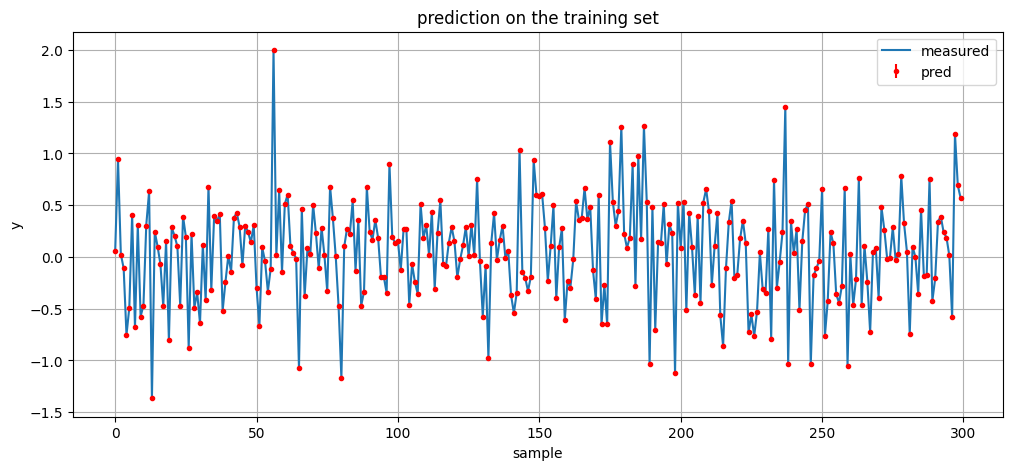

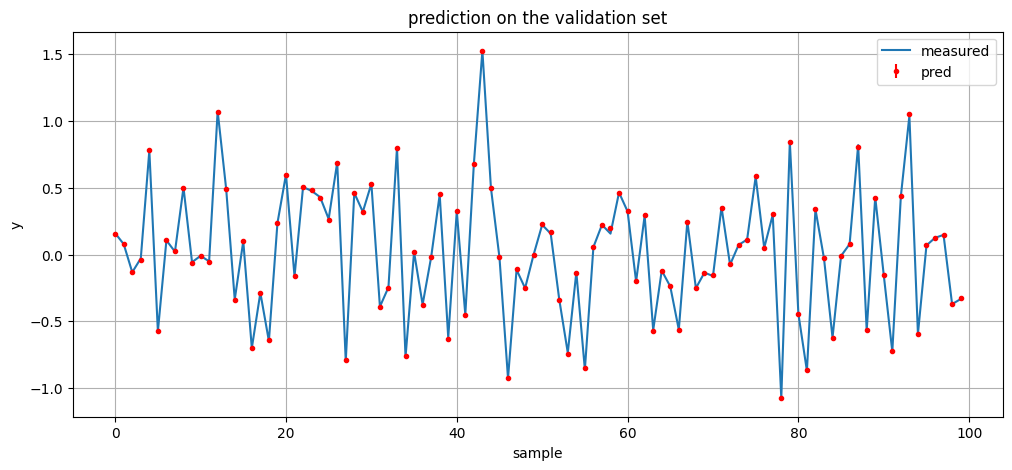

Validation NRMS= 0.012993975802294508


In [287]:
#fitting
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel,Matern, RationalQuadratic, ExpSineSquared, DotProduct
from sklearn.metrics import mean_squared_error


# TRYING OUT DIFFERENT KERNEL(S)
#ker = DotProduct(sigma_0=1.0, sigma_0_bounds=(1e-5, 1e5)) + ExpSineSquared(length_scale=1.0, periodicity=1.0)
#ker = DotProduct(sigma_0=1.0, sigma_0_bounds=(1e-5, 1e5))
#ker = ExpSineSquared(length_scale=1.0, periodicity=1.0)
#ker = Matern(length_scale= 0.1, nu = 2.5) + WhiteKernel(noise_level=0.01) + RationalQuadratic(length_scale=0.1)
#ker = Matern(length_scale= 0.1, nu = 2.5) + WhiteKernel(noise_level=0.01) +  RBF(length_scale=0.1) + RationalQuadratic(length_scale=0.1)
#ker = Matern(length_scale= 0.1, nu = 2.5) + WhiteKernel(noise_level=0.01) #a=)
#ker = RBF(length_scale=0.1) + RationalQuadratic(length_scale=1.0, alpha=0.1) + WhiteKernel(noise_level=0.01)
#ker = RationalQuadratic(length_scale=0.1) + RBF(length_scale=0.1) + WhiteKernel(noise_level=0.01)
#ker = RationalQuadratic(length_scale=0.1) + WhiteKernel(noise_level=0.01) #a=)
#ker = Matern(length_scale= 0.1, nu = 2.5) + WhiteKernel(noise_level=0.01) + RBF(length_scale=0.1)


reg = GaussianProcessRegressor(ker, n_restarts_optimizer=10) #a=)
reg.fit(Xtrain,Ytrain) #a)

#residual calculations and plotting
Ytrain_pred, Ytrain_pred_std = reg.predict(Xtrain,return_std=True) #a)
plt.figure(figsize=(12,5)) #a)
plt.plot(Ytrain) #a)
plt.title('prediction on the training set')
Ytrain_pred, Ytrain_pred_std = reg.predict(Xtrain,return_std=True) #a)
plt.errorbar(np.arange(len(Xtrain)), (Ytrain_pred), yerr=2*Ytrain_pred_std,fmt='.r') #a)
plt.grid(); plt.xlabel('sample'); plt.ylabel('y'); plt.legend(['measured','pred'])#a)
plt.show() #a)

plt.figure(figsize=(12,5)) #a)
plt.title('prediction on the validation set')
plt.plot(Yval) #a)
Yval_pred, Yval_pred_std = reg.predict(Xval,return_std=True) #a)
plt.errorbar(np.arange(len(Xval)), (Yval_pred), yerr=2*Yval_pred_std,fmt='.r') #a)
plt.grid(); plt.xlabel('sample'); plt.ylabel('y'); plt.legend(['measured','pred']) #a)
plt.show() #a)

print(f'Validation NRMS= {np.mean((Yval_pred-Yval)**2)**0.5/np.std(Yval)}')#a)





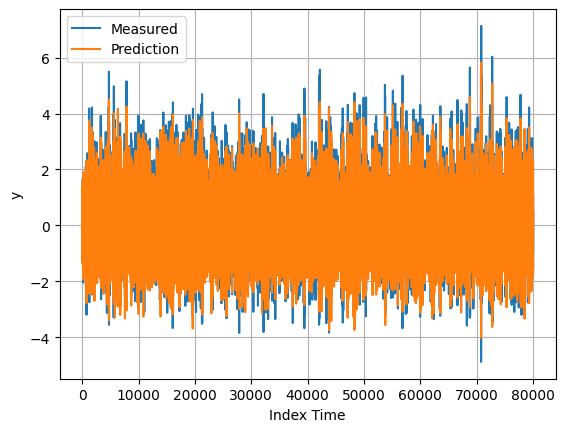

Test NRMS: 0.965847911851755


In [288]:
"""
#Testing NARX (RBF) with a test set
np.random.seed(43)
utest = Xdata
ytest = use_NARX_model_in_simulation(utest,f,na,nb)


model_now = reg #b=)
fmodel = lambda u,y: model_now.predict(np.concatenate([u,y])[None,:])[0] 
ytest_sim = use_NARX_model_in_simulation(utest, fmodel, na, nb)


plt.plot(ytest) #b)
plt.plot(ytest-ytest_sim) #b)
plt.grid(); plt.xlabel('index time'); plt.ylabel('y'); plt.legend(['measured','prediction']) #b)
plt.show() #b)

print('NRMS=',np.mean((ytest-ytest_sim)**2)**0.5/np.std(ytest)) #b)
"""

"""
# Testing NARX (Matern Kernel) with a test set
np.random.seed(43)
utest = Xdata
ytest = use_NARX_model_in_simulation(utest, f, na, nb)

model_now_matern = reg_matern
fmodel_matern = lambda u, y: model_now_matern.predict(np.concatenate((u[:nb, np.newaxis], y[:na, np.newaxis]), axis=0))[0]
ytest_sim_matern = use_NARX_model_in_simulation(utest, fmodel_matern, na, nb)

plt.plot(ytest)
plt.plot(ytest - ytest_sim_matern)
plt.grid()
plt.xlabel('Index time')
plt.ylabel('y')
plt.legend(['Measured', 'Prediction'])
plt.show()

print('NRMS (Matérn kernel) =', np.mean((ytest - ytest_sim_matern) ** 2) ** 0.5 / np.std(ytest))
"""

"""
# Testing NARX (Rational Quadratic) using a test set 
np.random.seed(43)
utest = Xdata
ytest = use_NARX_model_in_simulation(utest, f, na, nb)

model_now = reg
fmodel = lambda u, y: model_now.predict(np.concatenate([u, y])[None, :])[0]
ytest_sim = use_NARX_model_in_simulation(utest, fmodel, na, nb)

plt.plot(ytest)
plt.plot(ytest - ytest_sim)
plt.grid()
plt.xlabel('Index Time')
plt.ylabel('y')
plt.legend(['Measured', 'Prediction'])
plt.show()

test_nrms = np.mean((ytest - ytest_sim) ** 2) ** 0.5 / np.std(ytest)
print('Test NRMS:', test_nrms)
"""


np.random.seed(43)
utest = Xdata
ytest = use_NARX_model_in_simulation(utest, f, na, nb)
model_now = reg

fmodel = lambda u, y: model_now.predict(np.concatenate([u, y])[None, :])[0]
ytest_sim = use_NARX_model_in_simulation(utest, fmodel, na, nb)

plt.plot(ytest)
plt.plot(ytest - ytest_sim)
plt.grid()
plt.xlabel('Index Time')
plt.ylabel('y')
plt.legend(['Measured', 'Prediction'])
plt.show()

test_nrms = np.mean((ytest - ytest_sim) ** 2) ** 0.5 / np.std(ytest)
print('Test NRMS:', test_nrms)
